## 1.3 確率的表現

In [1]:
from pgmpy.base import DAG
from pgmpy.models import BayesianNetwork
from pgmpy.factors.discrete import TabularCPD
from mypkg.display import display_graph
import numpy as np
import pandas as pd

変数に同時確率分布を導入する。この同時分布は「大域的分布」と呼ばれる。

パラメータ数が多くなると大域的分布の分析が困難になるが、DAGの情報を使うことで大域的分布を局所的分布に分解でき、分析が容易になる。

DAGが非循環であることは、大域的分布を局所的分布に分解できることを意味している。

In [2]:
# 年齢の確率表
A_prob = pd.Series([0.3, 0.5, 0.2], index=["young", "adult", "old"]).to_frame("A_prob")

# 性別の確率表
S_prob = pd.Series([0.6, 0.4], index=["M", "F"]).to_frame("S_prob")

display(A_prob)
display(S_prob)

,A_prob
young,0.3
adult,0.5
old,0.2


,S_prob
M,0.6
F,0.4


In [3]:
# 職業の確率表
O_prob = pd.DataFrame(
    [[0.96, 0.92], [0.04, 0.08]], columns=["high", "uni"], index=["emp", "self"]
)
O_prob.columns.name = "E"

# 居住地の確率表
R_prob = pd.DataFrame(
    [[0.25, 0.2], [0.75, 0.8]], columns=["high", "uni"], index=["small", "big"]
)
R_prob.columns.name = "E"

display(O_prob)
display(R_prob)

E,high,uni
emp,0.96,0.92
self,0.04,0.08


E,high,uni
small,0.25,0.2
big,0.75,0.8


In [4]:
# 教育水準の確率表
E_data = (
    np.array([0.75, 0.25, 0.72, 0.28, 0.88, 0.12, 0.64, 0.36, 0.70, 0.30, 0.90, 0.10])
    .reshape(-1, 2)
    .T
)
E_prob = pd.DataFrame(
    E_data,
    columns=pd.MultiIndex.from_product(
        (["young", "adult", "old"], ["M", "F"]), names=["A", "S"]
    ),
    index=["high", "uni"],
)

# 交通手段の確率表
T_data = (
    np.array([0.48, 0.42, 0.10, 0.56, 0.36, 0.08, 0.58, 0.24, 0.18, 0.70, 0.21, 0.09])
    .reshape(-1, 3)
    .T
)
T_prob = pd.DataFrame(
    T_data,
    columns=pd.MultiIndex.from_product(
        (["emp", "self"], ["small", "big"]), names=["O", "R"]
    ),
    index=["car", "train", "other"],
)

display(E_prob)
display(T_prob)

A    young       adult        old     
S        M     F     M     F    M    F
high  0.75  0.72  0.88  0.64  0.7  0.9
uni   0.25  0.28  0.12  0.36  0.3  0.1

O       emp        self      
R     small   big small   big
car    0.48  0.56  0.58  0.70
train  0.42  0.36  0.24  0.21
other  0.10  0.08  0.18  0.09

DAGと局所的分布を結合して、ベイジアンネットワークを構築する。

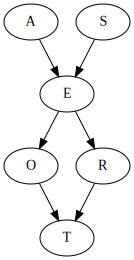

In [5]:
# DAGをもう一度作成する
dag = DAG([("A", "E"), ("S", "E"), ("E", "O"), ("E", "R"), ("O", "T"), ("R", "T")])
display_graph(dag.to_graphviz())

In [6]:
# ベイジアンネットワークのオブジェクトを作成する
bn = BayesianNetwork(dag)

In [7]:
# CPDオブジェクトを作成する
A_cpd = TabularCPD(
    variable="A",
    variable_card=3,
    values=A_prob.values,
    state_names={"A": ["young", "adult", "old"]},
)

S_cpd = TabularCPD(
    variable="S",
    variable_card=2,
    values=S_prob.values,
    state_names={"S": ["M", "F"]},
)

O_cpd = TabularCPD(
    variable="O",
    variable_card=2,
    values=O_prob.values,
    evidence=O_prob.columns.names,
    evidence_card=[2],
    state_names={
        "O": ["emp", "self"],
        "E": ["high", "uni"],
    },
)

R_cpd = TabularCPD(
    variable="R",
    variable_card=2,
    values=R_prob.values,
    evidence=R_prob.columns.names,
    evidence_card=[2],
    state_names={
        "R": ["small", "big"],
        "E": ["high", "uni"],
    },
)

E_cpd = TabularCPD(
    variable="E",
    variable_card=2,
    values=E_prob.values,
    evidence=E_prob.columns.names,
    evidence_card=[3, 2],
    state_names={
        "E": ["high", "uni"],
        "A": ["young", "adult", "old"],
        "S": ["M", "F"],
    },
)

T_cpd = TabularCPD(
    variable="T",
    variable_card=3,
    values=T_prob.values,
    evidence=T_prob.columns.names,
    evidence_card=[2, 2],
    state_names={
        "T": ["car", "train", "other"],
        "O": ["emp", "self"],
        "R": ["small", "big"],
    },
)

In [11]:
# 交通手段のCPDを見てみる
print(T_cpd)

+----------+----------+--------+----------+---------+
| O        | O(emp)   | O(emp) | O(self)  | O(self) |
+----------+----------+--------+----------+---------+
| R        | R(small) | R(big) | R(small) | R(big)  |
+----------+----------+--------+----------+---------+
| T(car)   | 0.48     | 0.56   | 0.58     | 0.7     |
+----------+----------+--------+----------+---------+
| T(train) | 0.42     | 0.36   | 0.24     | 0.21    |
+----------+----------+--------+----------+---------+
| T(other) | 0.1      | 0.08   | 0.18     | 0.09    |
+----------+----------+--------+----------+---------+


In [8]:
# ベイジアンネットワークのオブジェクトにCPDを格納する
bn.add_cpds(A_cpd, S_cpd, E_cpd, O_cpd, R_cpd, T_cpd)

# CPDが要件を満たしているかを確認する
# TrueならOK
bn.check_model()

True